<a href="https://colab.research.google.com/github/m-costantini/Set-wise_Coordinate_Descent/blob/master/main_paral_distrib_Nmax_scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code of Experiment A, parallel distributed setting, in "Set-wise Coordinate Descent for Dual Asynchronous Decentralized Optimization", Marina Costantini, Nikolaos Liakopoulos, Panayotis Mertikopoulos, Thrasyvoulos Spyropoulos, submitted to IEEE Transactions on Automatic Control

Author: Marina Costantini

marina.costantini@eurecom.fr

August 2023

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Import common libraries
import numpy as np
import math
import networkx as nx
import copy
from random import choice
import matplotlib.pyplot as plt

# Import my own functions
import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/Set-wise_Coordinate_Descent')

# New imports
!cp -R -u -p /content/drive/MyDrive/Colab\ Notebooks/Set-wise_Coordinate_Descent/{paral_distr_problems.py,paral_distr_solvers.py,functions.py} /content/

for mod_name in ["paral_distr_problems","paral_distr_solvers","functions"]:
    if mod_name in sys.modules:
        del sys.modules[mod_name]

from functions import *
from paral_distr_problems import QuadraticProblem
from paral_distr_solvers import Distrib_SxCD


In [ ]:
# Select seed for reproducibility

seed = 710 # change to get different results
print("seed =", seed)
np.random.seed(seed)
random.seed(seed)

### Run experiment



In [ ]:
seed =  4203 # <-- loc=10, scale=3, 1 / 100 <=== USED FOR v7
np.random.seed(seed)
print("seed = ", seed)

# Create dummy graph to distribute coordiantes
param_list = [(12,8), (24,4)] # (sets/nodes, coords_per_set/degree)
G_list = []
for params in param_list:
    B = nx.watts_strogatz_graph(params[0], params[1], 0)
    G_list.append( np.array( nx.to_numpy_array(B) ).astype(int) )

# Distribute coordinates in sets
A_list = []
for G in G_list:
    A_list.append( (get_edge_matrix(G)).astype(bool).T )

coord_set_list = []
for A in A_list:
    coord_set = []
    for row in A:
        coord_set.append( np.where(row)[0] )
    coord_set_list.append(coord_set)

# Sanity check - see also in what sets each coordinate is
set_belonging_list = []
for A in A_list:
    set_belonging = []
    for row in A.T:
        set_belonging.append( np.where(row)[0] )
    set_belonging_list.append(coord_set)

non_zero_list = []
E_list = []
for G in G_list:
    A = get_edge_matrix(G)
    E_list.append( np.shape(A)[0] )
    role, neighbors, N, nodes_edges = create_node_variables(A)
    _, mat_edge_idxs, _ = create_edge_variables(A, neighbors)
    n = np.shape(G)[0]
    non_zero = []
    for i in range(0, n, 2):
        non_zero.append( mat_edge_idxs[i,i+1] )
    non_zero_list.append(non_zero)

# Check that E is the same for both coordinate distributions (therwise there is a problem)
if not all(E == E_list[0] for E in E_list):
    print("WARNING !! --> Elemens in E_list are not all equal")

# Create quadratic problem
E = E_list[0]
quad_factor = np.random.normal(loc=10, scale=3, size=(E,))
if any(quad_factor <= 0):
    raise Exception("Negative quadratic coefficient !!")
P = np.diag(quad_factor)
min_sz = 1 / max(quad_factor)
significant_digits = 1
sz = 0.9 * min_sz
alpha = round(sz, significant_digits - int(math.floor(math.log10(abs(sz)))) - 1)


algos_to_run = ['SU-CD', 'SGS-CD']
results = [None for i in range(len(coord_set_list))]
steps = 10000
for idx_cs, coord_set in enumerate(coord_set_list):
    print("\n Running coord distribution", idx_cs+1, "/", len(coord_set_list))
    the_problem = QuadraticProblem(coord_set, P)
    obj_vals = {}
    for algo_name in algos_to_run:
        print("\tRunning ", algo_name)
        the_solver = Distrib_SxCD(the_problem, algo_name, coord_set, non_zero_list[idx_cs], steps, alpha)
        obj_vals[algo_name] = the_solver.solve()
    results[idx_cs] = obj_vals





seed =  4203

 Running coord distribution 1 / 2
	Running  SU-CD
 --> Precision < 10^(-9) reached @ iter 8273  --> leave!
	Running  SGS-CD
 --> Precision < 10^(-9) reached @ iter 1229  --> leave!

 Running coord distribution 2 / 2
	Running  SU-CD
 --> Precision < 10^(-9) reached @ iter 7883  --> leave!
	Running  SGS-CD
 --> Precision < 10^(-9) reached @ iter 1956  --> leave!


#### Plots with slope estiamtion

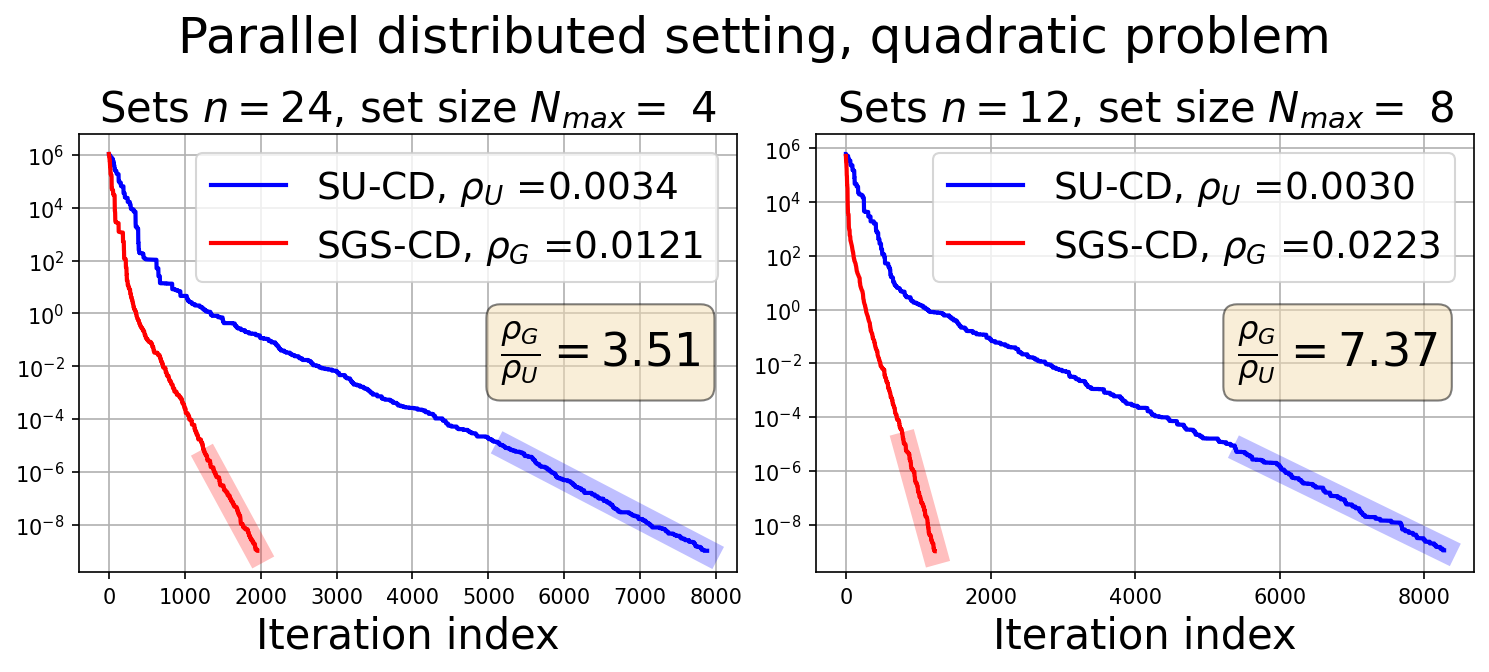

In [ ]:
fontsz = {'legends':14, 'axes':16, 'titles':18, 'suptitles':20}
figsz = (6*len(coord_set_list), 5)

color = {'SU-CD':'blue', 'SGS-CD':'red'}
linestyle = {'SU-CD':'-', 'SGS-CD':'-'}


"""'''''' Rate estimation ''''''"""

plot_fitting = False
if plot_fitting:
    fig, ax = plt.subplots(1, len(coord_set_list), figsize=figsz)
m_list = [[None for i in range(len(coord_set_list))] for j in range(len(algos_to_run))]
b_list = [[None for i in range(len(coord_set_list))] for j in range(len(algos_to_run))]
sel_idcs_list = [[None for i in range(len(coord_set_list))] for j in range(len(algos_to_run))]

for idx_cs in range(len(coord_set_list)):
    obj_vals = results[idx_cs]
    for idx_algo, algo in enumerate(algos_to_run):
        subopt = abs(1 - obj_vals[algo]/the_problem.opt_val)
        idcs_nz_subopt = np.argwhere(subopt > 0).flatten()
        non_zero_subopt = subopt[idcs_nz_subopt]
        third_steps = int(len(non_zero_subopt)/3)
        sel_idcs_subopt = idcs_nz_subopt[2*third_steps:]
        sel_subopt_vals = non_zero_subopt[2*third_steps:]
        m, b = np.polyfit(sel_idcs_subopt, np.log(sel_subopt_vals), 1)
        if plot_fitting:
            ax[idx_cs].plot(sel_idcs_subopt, np.log(sel_subopt_vals), color=color[algo], linestyle=linestyle[algo], label=algo)
            ax[idx_cs].plot( sel_idcs_subopt, m*sel_idcs_subopt+b, 'k--')
        m_list[idx_algo][idx_cs] = m
        b_list[idx_algo][idx_cs] = b
        sel_idcs_list[idx_algo][idx_cs] = sel_idcs_subopt

rho_strs = {'SU-CD': r", $\rho_U$ =", 'SGS-CD': r", $\rho_G$ ="}


"""'''''' Plots for paper ''''''"""

fontsz = {'legends':18, 'axes':20, 'titles':20, 'suptitles':24}
figsz = (6*len(G_list), 4)

fig, ax = plt.subplots(1, len(G_list), figsize=figsz, dpi=150)

rate_list = [[None for i in range(len(coord_set_list))] for j in range(len(algos_to_run))]
for idx_cs in range(len(coord_set_list)):
    idx_ax = 1 - idx_cs
    obj_vals = results[idx_cs]
    for idx_algo, algo in enumerate(algos_to_run):
        rate = 1 - np.exp(m_list[idx_algo][idx_cs])

        suboptim = abs(1 - obj_vals[algo]/the_problem.opt_val)
        ax[idx_ax].plot(suboptim, color=color[algo], linestyle=linestyle[algo], label=algo + rho_strs[algo] + "{:.4f}".format(rate), linewidth=2)

        support = sel_idcs_list[idx_algo][idx_cs]
        subopt = suboptim[support[0]]
        support_2 = np.linspace(1, len(support), len(support))
        ax[idx_ax].plot(support, (1-rate)**support_2 * subopt, color=color[algo], linewidth=12, alpha=0.25)
        rate_list[idx_algo][idx_cs] = rate

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for idx_cs in range(len(coord_set_list)):
    idx_ax = 1 - idx_cs
    ax[idx_ax].set_xlabel('Iteration index', fontsize=fontsz['axes'])
    ax[idx_ax].grid()
    ax[idx_ax].set_yscale("log")

    params = param_list[idx_cs]
    title_str = 'Sets ' + r'$n = $' + str(params[0]) + r', set size $N_{max} =$ ' + str(params[1])

    ax[idx_ax].set_title(title_str, fontsize=fontsz['titles'])
    ax[idx_ax].legend(fontsize=fontsz['legends'])

    textstr = r'$\frac{\rho_G}{\rho_U}=%.2f$' % (rate_list[1][idx_cs]/rate_list[0][idx_cs], )
    pos_box = (0.64, 0.58)
    ax[idx_ax].text(pos_box[0], pos_box[1], textstr, transform=ax[idx_ax].transAxes, fontsize=fontsz['legends']+4,
        verticalalignment='top', bbox=props)

suptitle_str = 'Parallel distributed setting, quadratic problem'
fig.suptitle(suptitle_str, fontsize=fontsz['suptitles'])

fig.subplots_adjust(
    left  = 0.125,  # the left side of the subplots of the figure
    right = 0.9,    # the right side of the subplots of the figure
    bottom = 0.05,   # the bottom of the subplots of the figure
    top = 0.78,      # the top of the subplots of the figure
    wspace = 0.12,   # the amount of width reserved for blank space between subplots
    hspace = 0.1)   # the amount of height reserved for white space between subplots
